In [ ]:
!pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 22.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.wh

In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchattacks


transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                 (0.5, 0.5, 0.5))])

batch_size=64;


train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



100%|██████████| 170498071/170498071 [00:02<00:00, 62581078.36it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


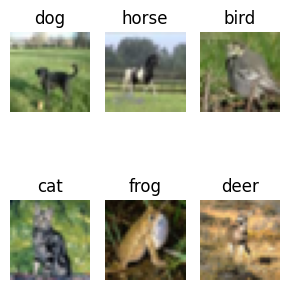

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

batch_size = 6

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Define the figure size
plt.figure(figsize=(3, 4))  # 6 columns and 4 rows

# Show images and print labels for the first 6 images
for i in range(batch_size):
    plt.subplot(2, 3, i+1)  # 2 rows, 3 columns, i+1 denotes the position of the subplot
    imshow(torchvision.utils.make_grid(images[i]))
    plt.title(f"{classes[labels[i]]}")
    plt.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) #This line applies the first convolutional layer (conv1) to the input x, then applies the ReLU activation function (torch.relu)
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8) #This line reshapes (flattens) the output tensor x from the previous layer to prepare it for the fully connected layers.
        x = torch.relu(self.fc1(x)) #This applies the ReLU activation function to the output of the first fully connected layer (fc1).
        x = self.fc2(x) #This applies the second fully connected layer (fc2) to produce the final output tensor x
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 5
for epoch in range(num_epochs): # loop over the dataset multiple times
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader: # get the inputs; images.to(device), labels.to(device) is a list of [images, labels]
        images, labels = images.to(device), labels.to(device)  # Move data to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = correct_val / total_val

    # Print training and validation statistics
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch 1/5, Loss: 1.3248, Train Accuracy: 0.5256, Val Accuracy: 0.6188
Epoch 2/5, Loss: 0.9529, Train Accuracy: 0.6644, Val Accuracy: 0.6497
Epoch 3/5, Loss: 0.7978, Train Accuracy: 0.7202, Val Accuracy: 0.7051
Epoch 4/5, Loss: 0.6817, Train Accuracy: 0.7606, Val Accuracy: 0.6980
Epoch 5/5, Loss: 0.5756, Train Accuracy: 0.7985, Val Accuracy: 0.7193


In [ ]:
torch.save(model.state_dict(), 'cifar10_model.pth')

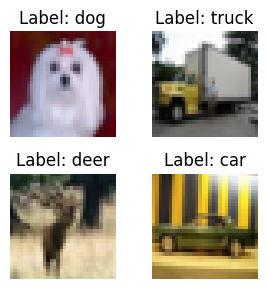

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
# Define the figure size
plt.figure(figsize=(3, 3))  # 3 columns and 4 rows

# Print images and labels for the first 4 images
for i in range(min(4, len(labels))):
    plt.subplot(2, 2, i+1)  # 2 rows, 2 columns, i+1 denotes the position of the subplot
    imshow(torchvision.utils.make_grid(images[i]))
    plt.title(f"Label: {classes[labels[i]]}")
    plt.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()


In [ ]:
model = SimpleCNN().to(device)
model.load_state_dict(torch.load('cifar10_model.pth'))

<All keys matched successfully>

In [ ]:
outputs = model(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  dog   truck deer  truck


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 71 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 81.3 %
Accuracy for class: car   is 85.7 %
Accuracy for class: bird  is 61.3 %
Accuracy for class: cat   is 56.4 %
Accuracy for class: deer  is 54.5 %
Accuracy for class: dog   is 56.4 %
Accuracy for class: frog  is 87.3 %
Accuracy for class: horse is 77.8 %
Accuracy for class: ship  is 81.3 %
Accuracy for class: truck is 77.3 %


Original Label: 2
The image has likely been attacked by an adversarial perturbation.


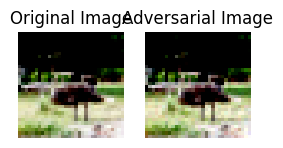

Original Prediction: horse
Adversarial Prediction: plane
Success Rate: 0.0001


In [ ]:
# Define the FGSM attack
attack_FGSM = torchattacks.FGSM(model, eps=8/255)

# Choose a random data point from the test dataset
index_FGSM = np.random.randint(0, len(test_dataset))
original_image_FGSM, original_label_FGSM = test_dataset[index_FGSM]
print("Original Label:", original_label_FGSM)

# Ensure original_label is a PyTorch tensor
original_label_tensor_FGSM = torch.tensor(original_label_FGSM)

# Apply the FGSM attack to the original image
adv_images_FGSM = attack_FGSM(original_image_FGSM.unsqueeze(0), original_label_tensor_FGSM.unsqueeze(0))

# Predictions on original and adversarial images
original_prediction_FGSM = torch.argmax(model(original_image_FGSM.unsqueeze(0)))
adversarial_prediction_FGSM = torch.argmax(model(adv_images_FGSM))

# Check if the predictions differ
if original_prediction_FGSM != adversarial_prediction_FGSM:
    print("The image has likely been attacked by an adversarial perturbation.")
else:
    print("The image has not been attacked by an adversarial perturbation.")


# Visualize the original image and adversarial image along with their predictions
fig, axs = plt.subplots(1, 2, figsize=(3, 5))

# Original image
axs[0].imshow(np.transpose(original_image_FGSM.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[0].set_title("Original Image")
axs[0].axis('off')

# Adversarial image
axs[1].imshow(np.transpose(adv_images_FGSM.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[1].set_title("Adversarial Image")
axs[1].axis('off')

plt.show()

# Print the original and adversarial predictions
print("Original Prediction:", classes[original_prediction_FGSM.item()])
print("Adversarial Prediction:", classes[adversarial_prediction_FGSM.item()])


# Check if the predictions differ

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = len(test_dataset)


if original_prediction_FGSM != adversarial_prediction_FGSM:
  successful_attacks += 1

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print("Success Rate:", success_rate)


**RFGSM Attack**

Original Label: 5


The image has likely been attacked by an adversarial perturbation.


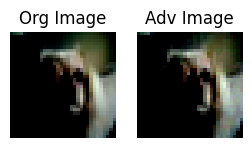

Original Prediction: dog
Adversarial Prediction: ship
Success Rate: 0.0001


In [ ]:
# The RFGSM Attack
attack_RGSM = torchattacks.RFGSM(model, eps=8/255)

# Choose a random data point from the test dataset
index_RFGSM = np.random.randint(0, len(test_dataset))
original_image_RFGSM, original_label_RFGSM = test_dataset[index_RFGSM]
print("Original Label:", original_label_RFGSM)

# Ensure original_label is a PyTorch tensor
original_label_tensor_RFGSM = torch.tensor(original_label_RFGSM)

# Apply the RFGSM attack to the original image
adv_images_RFGSM = attack_RGSM(original_image_RFGSM.unsqueeze(0), original_label_tensor_RFGSM.unsqueeze(0))

# Predictions on original and adversarial images
original_prediction_RFGSM = torch.argmax(model(original_image_RFGSM.unsqueeze(0)))
adversarial_prediction_RFGSM = torch.argmax(model(adv_images_RFGSM))

# Check if the predictions differ
if original_prediction_RFGSM != adversarial_prediction_RFGSM:
    print("The image has likely been attacked by an adversarial perturbation.")
else:
    print("The image has not been attacked by an adversarial perturbation.")



# Visualize the original image and adversarial image along with their predictions
fig, axs = plt.subplots(1, 2, figsize=(3, 5))


# Original image
axs[0].imshow(np.transpose(original_image_RFGSM.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[0].set_title("Org Image")
axs[0].axis('off')

# Adversarial image
axs[1].imshow(np.transpose(adv_images_RFGSM.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[1].set_title("Adv Image")
axs[1].axis('off')

plt.show()

# Print the original and adversarial predictions
print("Original Prediction:", classes[original_prediction_RFGSM.item()])
print("Adversarial Prediction:", classes[adversarial_prediction_RFGSM.item()])


# Check if the predictions differ

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = len(test_dataset)

if original_prediction_RFGSM != adversarial_prediction_RFGSM:
  successful_attacks += 1

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print("Success Rate:", success_rate)



**PGD Attack**

Original Label: 1
The image has likely been attacked by an adversarial perturbation.


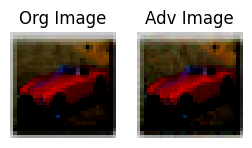

Original Prediction: car
Adversarial Prediction: plane
Success Rate: 0.0001


In [ ]:
# The PGD Attack
attack_PGD = torchattacks.PGD(model, eps=8/255)

# Choose a random data point from the test dataset
index_PGD = np.random.randint(0, len(test_dataset))
original_image_PGD, original_label_PGD = test_dataset[index_PGD]
print("Original Label:", original_label_PGD)

# Ensure original_label is a PyTorch tensor
original_label_tensor_PGD = torch.tensor(original_label_PGD)

# Apply the PGD attack to the original image
adv_images_PGD = attack_PGD(original_image_PGD.unsqueeze(0), original_label_tensor_PGD.unsqueeze(0))

# Predictions on original and adversarial images
original_prediction_PGD = torch.argmax(model(original_image_PGD.unsqueeze(0)))
adversarial_prediction_PGD = torch.argmax(model(adv_images_PGD))

# Check if the predictions differ
if original_prediction_PGD != adversarial_prediction_PGD:
    print("The image has likely been attacked by an adversarial perturbation.")
else:
    print("The image has not been attacked by an adversarial perturbation.")


# Visualize the original image and adversarial image along with their predictions
fig, axs = plt.subplots(1, 2, figsize=(3, 5))


# Original image
axs[0].imshow(np.transpose(original_image_PGD.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[0].set_title("Org Image")
axs[0].axis('off')

# Adversarial image
axs[1].imshow(np.transpose(adv_images_PGD.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[1].set_title("Adv Image")
axs[1].axis('off')

plt.show()


# Print the original and adversarial predictions
print("Original Prediction:", classes[original_prediction_PGD.item()])
print("Adversarial Prediction:", classes[adversarial_prediction_PGD.item()])


# Check if the predictions differ

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = len(test_dataset)

if original_prediction_PGD != adversarial_prediction_PGD:
  successful_attacks += 1

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print("Success Rate:", success_rate)


EOTPGD Attack

Original Label: 4
The image has likely been attacked by an adversarial perturbation.


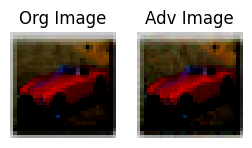

Original Prediction: deer
Adversarial Prediction: frog
Success Rate: 0.0001


In [ ]:
# The EOTPGD Attack
attack_EOTPGD = torchattacks.EOTPGD(model, eps=8/255)

# Choose a random data point from the test dataset
index_EOTPGD = np.random.randint(0, len(test_dataset))
original_image_EOTPGD, original_label_EOTPGD = test_dataset[index_EOTPGD]
print("Original Label:", original_label_EOTPGD)

# Ensure original_label is a PyTorch tensor
original_label_tensor_EOTPGD = torch.tensor(original_label_EOTPGD)

# Apply the EOTPGD attack to the original image
adv_images_EOTPGD = attack_EOTPGD(original_image_EOTPGD.unsqueeze(0), original_label_tensor_EOTPGD.unsqueeze(0))

# Predictions on original and adversarial images
original_prediction_EOTPGD = torch.argmax(model(original_image_EOTPGD.unsqueeze(0)))
adversarial_prediction_EOTPGD = torch.argmax(model(adv_images_EOTPGD))

# Check if the predictions differ
if original_prediction_EOTPGD != adversarial_prediction_EOTPGD:
    print("The image has likely been attacked by an adversarial perturbation.")
else:
    print("The image has not been attacked by an adversarial perturbation.")


# Visualize the original image and adversarial image along with their predictions
fig, axs = plt.subplots(1, 2, figsize=(3, 5))


# Original image
axs[0].imshow(np.transpose(original_image_PGD.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[0].set_title("Org Image")
axs[0].axis('off')

# Adversarial image
axs[1].imshow(np.transpose(adv_images_PGD.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[1].set_title("Adv Image")
axs[1].axis('off')

plt.show()


# Print the original and adversarial predictions
print("Original Prediction:", classes[original_prediction_EOTPGD.item()])
print("Adversarial Prediction:", classes[adversarial_prediction_EOTPGD.item()])


# Check if the predictions differ

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = len(test_dataset)

if original_prediction_EOTPGD != adversarial_prediction_EOTPGD:
  successful_attacks += 1

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print("Success Rate:", success_rate)

FFGSM Attack

Original Label: 5
The image has likely been attacked by an adversarial perturbation.


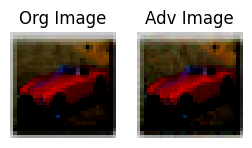

Original Prediction: dog
Adversarial Prediction: bird
Success Rate: 0.0001


In [ ]:
# The FFGSM Attack
attack_FFGSM = torchattacks.FFGSM(model, eps=8/255)

# Choose a random data point from the test dataset
index_FFGSM = np.random.randint(0, len(test_dataset))
original_image_FFGSM, original_label_FFGSM = test_dataset[index_FFGSM]
print("Original Label:", original_label_FFGSM)

# Ensure original_label is a PyTorch tensor
original_label_tensor_FFGSM = torch.tensor(original_label_FFGSM)

# Apply the FFGSM attack to the original image
adv_images_FFGSM = attack_FFGSM(original_image_FFGSM.unsqueeze(0), original_label_tensor_FFGSM.unsqueeze(0))

# Predictions on original and adversarial images
original_prediction_FFGSM = torch.argmax(model(original_image_FFGSM.unsqueeze(0)))
adversarial_prediction_FFGSM = torch.argmax(model(adv_images_FFGSM))

# Check if the predictions differ
if original_prediction_FFGSM != adversarial_prediction_FFGSM:
    print("The image has likely been attacked by an adversarial perturbation.")
else:
    print("The image has not been attacked by an adversarial perturbation.")


# Visualize the original image and adversarial image along with their predictions
fig, axs = plt.subplots(1, 2, figsize=(3, 5))


# Original image
axs[0].imshow(np.transpose(original_image_PGD.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[0].set_title("Org Image")
axs[0].axis('off')

# Adversarial image
axs[1].imshow(np.transpose(adv_images_PGD.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[1].set_title("Adv Image")
axs[1].axis('off')

plt.show()


# Print the original and adversarial predictions
print("Original Prediction:", classes[original_prediction_FFGSM.item()])
print("Adversarial Prediction:", classes[adversarial_prediction_FFGSM.item()])


# Check if the predictions differ

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = len(test_dataset)

if original_prediction_FFGSM != adversarial_prediction_FFGSM:
  successful_attacks += 1

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print("Success Rate:", success_rate)

**`Comparing all attack models`**

In [ ]:
# Define the FGSM attack
attack_FGSM = torchattacks.FGSM(model, eps=8/255)

# Define the UPGD attack
attack_RFGSM = torchattacks.RFGSM(model, eps=8/255, alpha=2/255, steps=10)

# Define the APGD attack
attack_PGD = torchattacks.PGD(model, eps=8/255, steps=10, random_start=False)

# Define the APGDT attack
attack_EOTPGD = torchattacks.EOTPGD(model, eps=8/255, alpha = 2 / 255, steps=10,  eot_iter=2, random_start=False)

# Define the DIFGSM attack
attack_FFGSM = torchattacks.FFGSM(model, eps=8/255, alpha=2/255)



# Initialize variables to count successful attacks
successful_attacks_FGSM = 0
successful_attacks_RFGSM = 0
successful_attacks_PGD = 0
successful_attacks_EOTPGD = 0
successful_attacks_FFGSM = 0

total_samples = len(test_dataset)

# Iterate over the test dataset
for original_image, original_label in test_dataset:
    # Ensure original_label is a PyTorch tensor
    original_label_tensor = torch.tensor(original_label)

    # Apply the FGSM attack to the original image
    adv_images_FGSM = attack_FGSM(original_image.unsqueeze(0), original_label_tensor.unsqueeze(0))
    # Apply the RFGSM attack to the original image
    adv_images_RFGSM = attack_RFGSM(original_image.unsqueeze(0), original_label_tensor.unsqueeze(0))
    # Apply the APGD attack to the original image
    adv_images_PGD = attack_PGD(original_image.unsqueeze(0), original_label_tensor.unsqueeze(0))
    # Apply the APGDT attack to the original image
    adv_images_EOTPGD = attack_EOTPGD(original_image.unsqueeze(0), original_label_tensor.unsqueeze(0))
    # Apply the DIFGSM attack to the original image
    adv_images_FFGSM = attack_FFGSM(original_image.unsqueeze(0), original_label_tensor.unsqueeze(0))


    # Predictions on original and adversarial images
    original_prediction = torch.argmax(model(original_image.unsqueeze(0)))
    adversarial_prediction_FGSM = torch.argmax(model(adv_images_FGSM))
    adversarial_prediction_RFGSM = torch.argmax(model(adv_images_RFGSM))
    adversarial_prediction_PGD = torch.argmax(model(adv_images_PGD))
    adversarial_prediction_EOTPGD = torch.argmax(model(adv_images_EOTPGD))
    adversarial_prediction_FFGSM = torch.argmax(model(adv_images_FFGSM))


    # Check if the predictions differ for FGSM attack
    if original_prediction != adversarial_prediction_FGSM:
        successful_attacks_FGSM += 1

    # Check if the predictions differ for UPGD attack
    if original_prediction != adversarial_prediction_RFGSM:
        successful_attacks_RFGSM += 1

    # Check if the predictions differ for APGD attack
    if original_prediction != adversarial_prediction_PGD:
        successful_attacks_PGD += 1

    # Check if the predictions differ for APGDT attack
    if original_prediction != adversarial_prediction_EOTPGD:
        successful_attacks_EOTPGD += 1

    # Check if the predictions differ for DIFGSM attack
    if original_prediction != adversarial_prediction_FFGSM:
        successful_attacks_FFGSM += 1



# Calculate the success rate for each attack
success_rate_FGSM = successful_attacks_FGSM / total_samples
success_rate_RFGSM = successful_attacks_RFGSM / total_samples
success_rate_PGD = successful_attacks_PGD / total_samples
success_rate_EOTPGD = successful_attacks_EOTPGD / total_samples
success_rate_FFGSM = successful_attacks_FFGSM / total_samples


# Print the success rates for each attack
print("FGSM Success Rate:", success_rate_FGSM)
print("RFGSM Success Rate:", success_rate_RFGSM)
print("PGD Success Rate:", success_rate_PGD)
print("EOTPGD Success Rate:", success_rate_EOTPGD)
print("FFGSM Success Rate:", success_rate_FFGSM)


# Compare which attack has the highest success rate
highest_success_rate = max(success_rate_FGSM, success_rate_RFGSM, success_rate_PGD, success_rate_EOTPGD, success_rate_FFGSM)
if highest_success_rate == success_rate_FGSM:
    print("FGSM has the highest success rate.")
elif highest_success_rate == success_rate_RFGSM:
    print("RFGSM has the highest success rate.")
elif highest_success_rate == success_rate_EOTPGD:
    print("EOTPGD has the highest success rate.")
elif highest_success_rate == success_rate_PGD:
    print("PGD has the highest success rate.")
else:
    print("FFGSM has the highest success rate.")

FGSM Success Rate: 0.7141
RFGSM Success Rate: 0.8549
PGD Success Rate: 0.8526
EOTPGD Success Rate: 0.8526
FFGSM Success Rate: 0.6707
RFGSM has the highest success rate.
